## Importing libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from geexhp import datagen, datamod, datavis, stages
datavis.configure_matplotlib(oldschool=False)

## Test 1 - Loading HWO configuration file for Modern Earth

In [ ]:
dg = datagen.DataGen()
config_str = dg.config_str
config_dict = dg._parse_config(config_str)

In [12]:
molecules = config_dict["ATMOSPHERE-LAYERS-MOLECULES"].split(',')
pressures = []
temperatures = []
concentration_dict = {mol: [] for mol in molecules}

for i in range(60):
    layer = config_dict.get(f"ATMOSPHERE-LAYER-{i + 1}").split(',')
    pressure = float(layer[0])
    temperature = float(layer[1])
    concentrations = [float(value) for value in layer[2:]]
    
    pressures.append(pressure)
    temperatures.append(temperature)
    for j, mol in enumerate(molecules):
        concentration_dict[mol].append(concentrations[j])

data = {
    "Pressure": pressures,
    "Temperature": temperatures
}
data.update(concentration_dict)
mixing_ratio = pd.DataFrame(data)

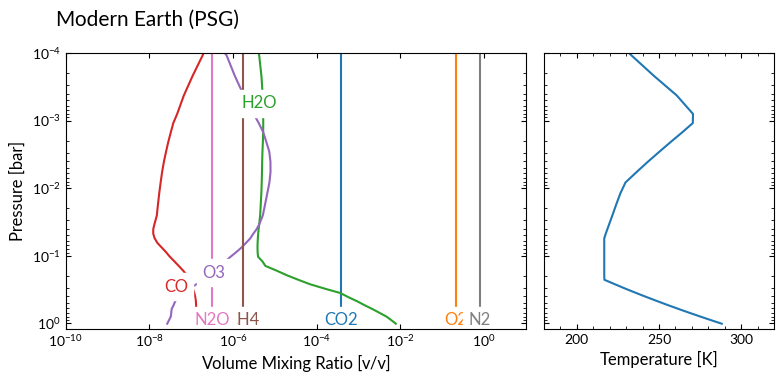

In [13]:
molecules = ["CO2","O2","H2O","CO","O3","CH4","N2O","N2"]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1.5]}, sharey=True)
for molecule in molecules:
    line, = ax[0].plot(mixing_ratio[molecule], mixing_ratio["Pressure"], label=molecule)
    x_pos = np.median(line.get_xdata())
    datavis.label_line(line, x=x_pos, label=molecule, align=False)
    
ax[0].invert_yaxis()
ax[0].axis([1e-10, 10, 1.2, 1e-4])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set(xlabel="Volume Mixing Ratio [v/v]", ylabel="Pressure [bar]")

mixing_ratio.plot(x="Temperature", y="Pressure", ax=ax[1], legend=False)
ax[1].invert_yaxis()
ax[1].axis([180, 320, 1.2, 1e-4])
ax[1].set(xlabel="Temperature [K]", ylabel="")
ax[1].set_yscale("log")

fig.suptitle("Modern Earth (PSG)", x=0.08, y=0.95, horizontalalignment='left', 
                verticalalignment='top', fontsize=15)
plt.tight_layout();

In [17]:
def test_instrument(config, instrument):
    wavelength, total, _, _ = dg._generate_spectrum_for_instrument(config, instrument)
    return pd.DataFrame({f"WAVELENGTH": wavelength, f"ALBEDO": total})

In [18]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
dfs = [test_instrument(config_str, instrument) for instrument in instruments]
habex = pd.concat(dfs).reset_index(drop=True)

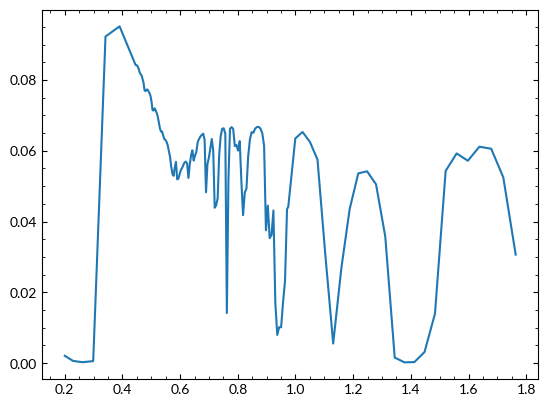

In [19]:
plt.plot(habex["WAVELENGTH"], habex["ALBEDO"]);

In [20]:
instruments = ["B-UV", "B-Vis", "B-NIR"]
dfs = [test_instrument(config_str, instrument) for instrument in instruments]
luvoir = pd.concat(dfs).reset_index(drop=True)

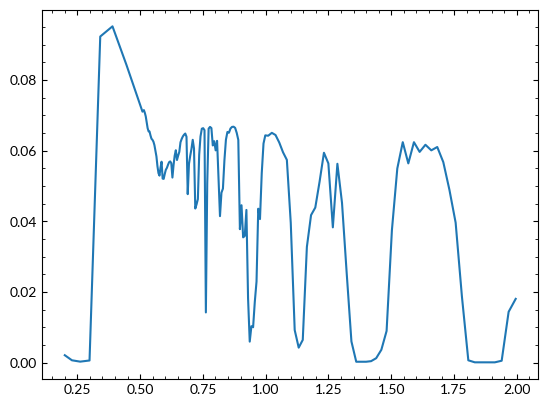

In [21]:
plt.plot(luvoir["WAVELENGTH"], luvoir["ALBEDO"]);

Since the spectra are similar, we will only do it for HaBex here, but the code can be rewritten to simulate it for LUVOIR.

## Test 2 - Changing the abundances

In [22]:
def test_abundance(config, instrument, gas, multiplier):
    modified_config = config.copy()
    elements = ["CO2", "O2", "H2O", "CO", "O3", "CH4", "N2O", "N2"]
    gas_index = elements.index(gas)
    
    for key, value in modified_config.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            gas_value = float(values[gas_index + 2])
            new_value = gas_value * multiplier
            values[gas_index + 2] = str(new_value)
            modified_config[key] = ','.join(values)

    datamod.set_instrument(modified_config, instrument)
    config = dg._serialize_config(modified_config)
    wavelength, total, _, _ = dg._generate_spectrum_for_instrument(config, instrument)
    return pd.DataFrame({f"WAVELENGTH": wavelength, f"ALBEDO": total})

In [24]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]

results_double_O2 = [test_abundance(config_dict, instrument, "O2", 2) for instrument in instruments]
results_no_O2 = [test_abundance(config_dict, instrument, "O2", 0) for instrument in instruments]

df_double_O2 = pd.concat(results_double_O2).reset_index(drop=True)
df_no_O2 = pd.concat(results_no_O2).reset_index(drop=True)

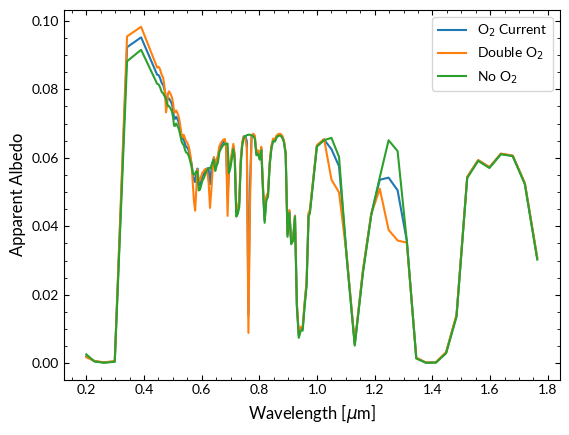

In [25]:
_, ax = plt.subplots()

ax.plot(habex["WAVELENGTH"], habex["ALBEDO"], label="O${}_2$ Current")
ax.plot(df_double_O2["WAVELENGTH"], df_double_O2["ALBEDO"], label="Double O${}_2$")
ax.plot(df_no_O2["WAVELENGTH"], df_no_O2["ALBEDO"], label="No O${}_2$")
ax.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax.legend();

In [26]:
results_double_H2O = [test_abundance(config_dict, instrument, "H2O", 2) for instrument in instruments]
results_no_H2O = [test_abundance(config_dict, instrument, "H2O", 0) for instrument in instruments]

df_double_H2O = pd.concat(results_double_H2O).reset_index(drop=True)
df_no_H2O = pd.concat(results_no_H2O).reset_index(drop=True)

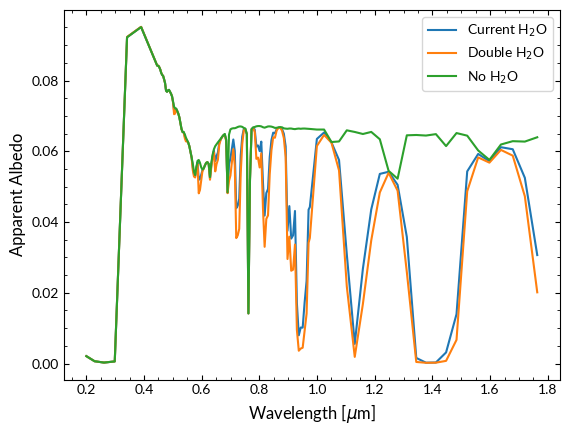

In [27]:
_, ax = plt.subplots()

ax.plot(habex["WAVELENGTH"], habex["ALBEDO"], label="Current H${}_2$O")
ax.plot(df_double_H2O["WAVELENGTH"], df_double_H2O["ALBEDO"], label="Double H${}_2$O")
ax.plot(df_no_H2O["WAVELENGTH"], df_no_H2O["ALBEDO"], label="No H${}_2$O")
ax.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax.legend();

In [28]:
results_double_O3 = [test_abundance(config_dict, instrument, "O3", 2) for instrument in instruments]
results_no_O3 = [test_abundance(config_dict, instrument, "O3", 0) for instrument in instruments]

df_double_O3 = pd.concat(results_double_O3).reset_index(drop=True)
df_no_O3 = pd.concat(results_no_O3).reset_index(drop=True)

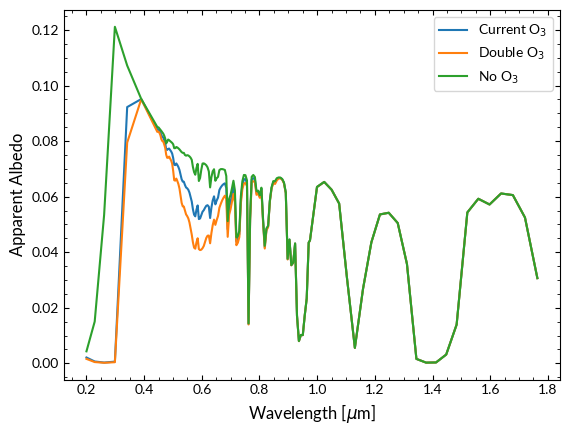

In [29]:
_, ax = plt.subplots()

ax.plot(habex["WAVELENGTH"], habex["ALBEDO"], label="Current O${}_3$")
ax.plot(df_double_O3["WAVELENGTH"], df_double_O3["ALBEDO"], label="Double O${}_3$")
ax.plot(df_no_O3["WAVELENGTH"], df_no_O3["ALBEDO"], label="No O${}_3$")
ax.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax.legend();

## Test 3 - Modifying atmospheric pressure (mbar)

In [30]:
def test_pressure(config, instrument, pressure):
    modified_config = config.copy()
    modified_config["ATMOSPHERE-PRESSURE"] = str(pressure)
    
    config = dg._serialize_config(modified_config)
    wavelength, total, _, _ = dg._generate_spectrum_for_instrument(config, instrument)
    return pd.DataFrame({f"WAVELENGTH": wavelength, f"ALBEDO": total})

In [31]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
pressures = [500, 1000, 1500]

df_half_atm = pd.concat(
    [test_pressure(config_dict.copy(), instrument, pressures[0]) for instrument in instruments]
).reset_index(drop=True)

df_1_0_atm = pd.concat(
    [test_pressure(config_dict.copy(), instrument, pressures[1]) for instrument in instruments]
).reset_index(drop=True)

df_1_5_atm = pd.concat(
    [test_pressure(config_dict.copy(), instrument, pressures[2]) for instrument in instruments]
).reset_index(drop=True)

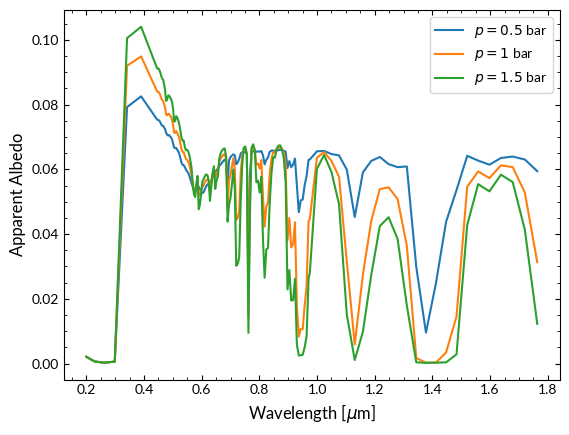

In [32]:
_, ax = plt.subplots()

ax.plot(df_half_atm["WAVELENGTH"], df_half_atm["ALBEDO"], label="$p = 0.5$ bar")
ax.plot(df_1_0_atm["WAVELENGTH"], df_1_0_atm["ALBEDO"], label="$p = 1$ bar")
ax.plot(df_1_5_atm["WAVELENGTH"], df_1_5_atm["ALBEDO"], label="$p = 1.5$ bar")
ax.set(xlabel="Wavelength [$\mu$m]", ylabel="Apparent Albedo")
ax.legend();

When atmospheric pressure decreases, it generally indicates a more rarefied atmosphere. On the other hand, higher atmospheric pressure suggests a denser and more expansive atmosphere. The correlation between atmospheric density and the visibility of spectral signatures is intrinsically linked to photon-molecule interaction. In a dense atmosphere, the molecules present have more opportunities to interact with photons, resulting in more pronounced spectral signatures. However, when the atmosphere is more rarefied, these interactions decrease, leading to significant attenuation of spectral signatures.

# Extra: How are other parameters influencing the spectrum?

In [33]:
def test_spectraltype(config, instrument, class_star):
    modified_config = config.copy()
    modified_config['OBJECT-STAR-TYPE'] = class_star
    modified_config['GEOMETRY-STELLAR-TYPE'] = class_star
    
    params = {
        'F': {'temp_range': (6000, 7220), 'radius_range': (1.18, 1.79), 'mag_range': (2.50, 4.22)},
        'G': {'temp_range': (5340, 5920), 'radius_range': (0.876, 1.12), 'mag_range': (4.40, 5.34)},
        'K': {'temp_range': (3940, 5280), 'radius_range': (0.552, 0.817), 'mag_range': (5.54, 7.59)},
        'M': {'temp_range': (2320, 3870), 'radius_range': (0.104, 0.559), 'mag_range': (7.75, 13.62)}
    }

    star_temperature = round(np.random.uniform(*params[class_star]['temp_range']), 3)
    star_radius = round(np.random.uniform(*params[class_star]['radius_range']), 3)
    star_mag = round(np.random.uniform(*params[class_star]['mag_range']), 3)

    modified_config['OBJECT-STAR-RADIUS'] = star_radius
    modified_config['OBJECT-STAR-TEMPERATURE'] = star_temperature
    modified_config['GEOMETRY-STELLAR-TEMPERATURE'] = star_temperature
    modified_config["GEOMETRY-STELLAR-MAGNITUDE"] = star_mag
    modified_config["GEOMETRY-OBS-ALTITUDE"] = 3

    config = dg._serialize_config(modified_config)
    wavelength, total, noise, _ = dg._generate_spectrum_for_instrument(config, instrument)

    noisy_albedo = np.random.normal(loc=total, scale=noise)
    df = pd.DataFrame({
        "WAVELENGTH": wavelength,
        "ALBEDO": total,
        "NOISE": noise,
        "NOISY_ALBEDO": noisy_albedo
    })
    return df

In [34]:
# Use LUVOIR too!
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
sts = ['F', 'G', 'K', 'M']

results_spectral_types = {
    st: [test_spectraltype(config_dict.copy(), instrument, st) for instrument in instruments]
    for st in sts
}

F = pd.concat(results_spectral_types['F']).reset_index(drop=True)
G = pd.concat(results_spectral_types['G']).reset_index(drop=True)
K = pd.concat(results_spectral_types['K']).reset_index(drop=True)
M = pd.concat(results_spectral_types['M']).reset_index(drop=True)

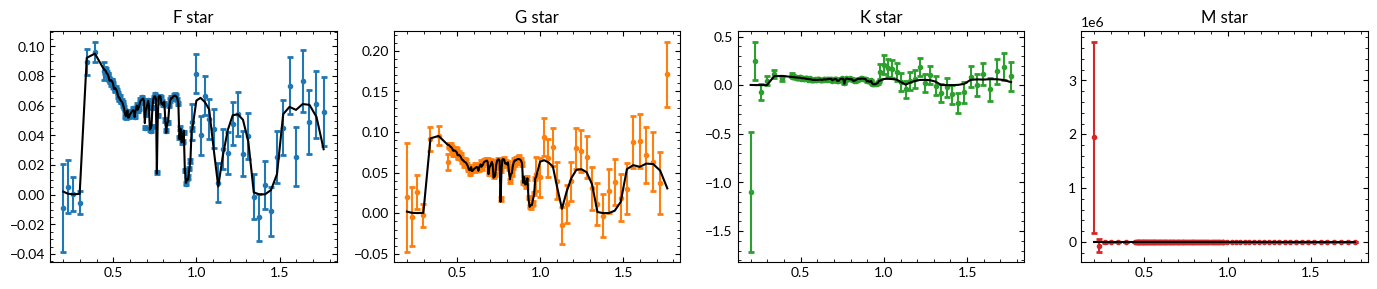

In [35]:
_, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(17,3))

ax1.errorbar(F["WAVELENGTH"], F["NOISY_ALBEDO"], yerr=F["NOISE"], fmt='.', capsize=2, capthick=2)
ax1.plot(F["WAVELENGTH"], F["ALBEDO"], color="k", zorder=3)
ax1.set_title("F star")

ax2.errorbar(G["WAVELENGTH"], G["NOISY_ALBEDO"], yerr=G["NOISE"], fmt='.', capsize=2, capthick=2, color="tab:orange")
ax2.plot(G["WAVELENGTH"], G["ALBEDO"], color="k", zorder=3)
ax2.set_title("G star")

ax3.errorbar(K["WAVELENGTH"], K["NOISY_ALBEDO"], yerr=K["NOISE"], fmt='.', capsize=2, capthick=2, color="tab:green")
ax3.plot(K["WAVELENGTH"], K["ALBEDO"], color="k", zorder=3)
ax3.set_title("K star")

ax4.errorbar(M["WAVELENGTH"], M["NOISY_ALBEDO"], yerr=M["NOISE"], fmt='.', capsize=2, capthick=2, color="tab:red")
ax4.plot(M["WAVELENGTH"], M["ALBEDO"], color="k", zorder=3)
ax4.set_title("M star");

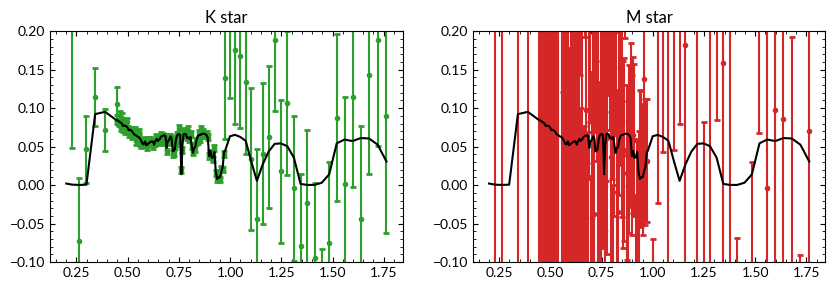

In [36]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.errorbar(K["WAVELENGTH"], K["NOISY_ALBEDO"], yerr=K["NOISE"], fmt='.', capsize=2, capthick=2, color="tab:green")
ax1.plot(K["WAVELENGTH"], K["ALBEDO"], color="k", zorder=3)
ax1.set_ylim(-0.1, 0.2)
ax1.set_title("K star")

ax2.errorbar(M["WAVELENGTH"], M["NOISY_ALBEDO"], yerr=M["NOISE"], fmt='.', capsize=2, capthick=2, color="tab:red")
ax2.plot(M["WAVELENGTH"], M["ALBEDO"], color="k", zorder=3)
ax2.set_ylim(-0.1, 0.2)
ax2.set_title("M star");

## 2.0Ga after the Great Oxidation Event (Proterozoic)

In [ ]:
dg_proterozoic = datagen.DataGen(stage="proterozoic")
config_str_pro = dg_proterozoic.config_str
config_dict_pro = dg_proterozoic._parse_config(config_str_pro)

In [39]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
dfs = [test_instrument(config_str_pro, instrument) for instrument in instruments]
proterozoic = pd.concat(dfs).reset_index(drop=True)

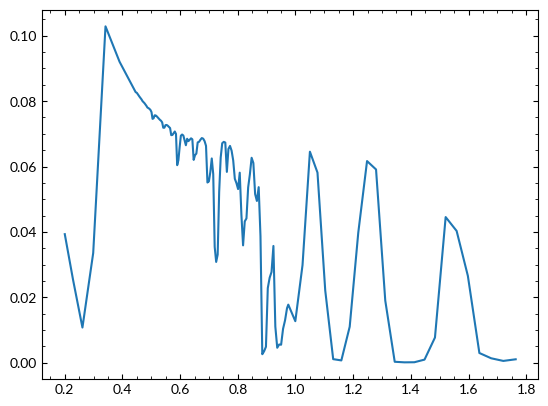

In [40]:
plt.plot(proterozoic["WAVELENGTH"], proterozoic["ALBEDO"]);

## Archean Earth

In [ ]:
dg_archean = datagen.DataGen(stage="archean")
config_str_arc = dg_archean.config_str
config_dict_arc = dg_archean._parse_config(config_str_arc)

In [42]:
instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
dfs = [test_instrument(config_str_arc, instrument) for instrument in instruments]
archean = pd.concat(dfs).reset_index(drop=True)

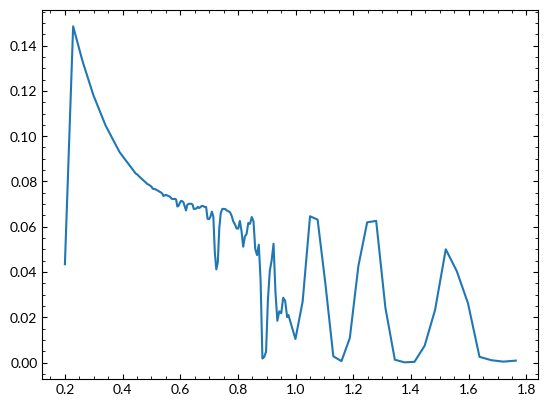

In [43]:
plt.plot(archean["WAVELENGTH"], archean["ALBEDO"]);

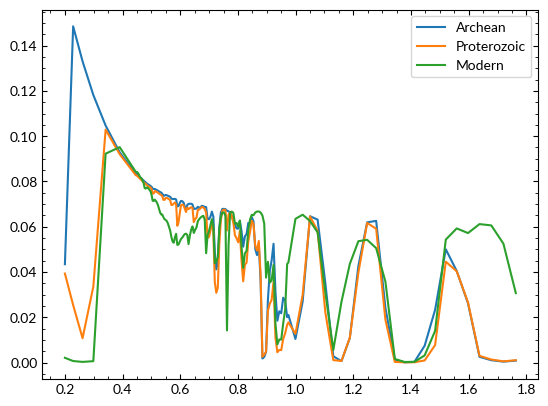

In [44]:
plt.plot(archean["WAVELENGTH"], archean["ALBEDO"], label="Archean")
plt.plot(proterozoic["WAVELENGTH"], proterozoic["ALBEDO"], label="Proterozoic")
plt.plot(habex["WAVELENGTH"], habex["ALBEDO"], label="Modern")
plt.legend();

## Generate a random modern earth

In [61]:
modified_config = config_dict.copy()
datamod.random_planet(modified_config, stages.molweightlist("modern"))

def test_random_planet(modified_config, instrument):
    config = dg._serialize_config(modified_config)
    wavelength, total, _, _ = dg._generate_spectrum_for_instrument(config, instrument)
    return pd.DataFrame({f"WAVELENGTH": wavelength, f"ALBEDO": total})

instruments = ["SS-UV", "SS-Vis", "SS-NIR"]
results = [test_random_planet(modified_config, instrument) for instrument in instruments]
spectrum = pd.concat(results).reset_index(drop=True)

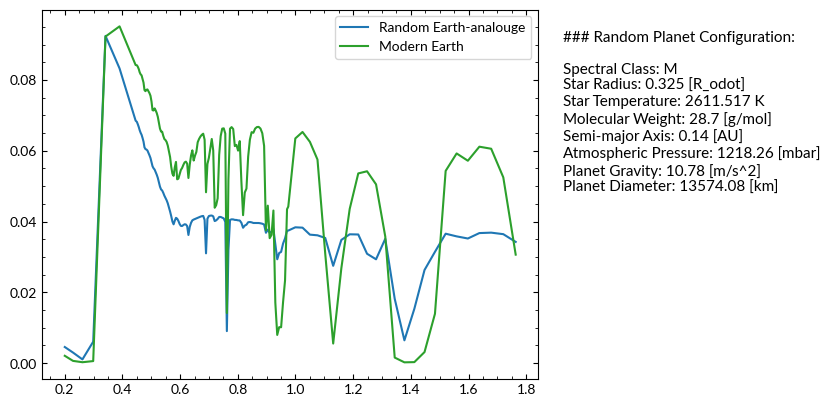

In [62]:
SPECTRAL_CLASS = modified_config['OBJECT-STAR-TYPE']
STAR_RADIUS = modified_config['OBJECT-STAR-RADIUS']
STAR_TEMPERATURE = modified_config['OBJECT-STAR-TEMPERATURE']
MOLECULAR_WEIGHT = round(modified_config['ATMOSPHERE-WEIGHT'], 2)
SEMI_MAJOR_AXIS = round(modified_config['OBJECT-STAR-DISTANCE'], 2)
ATMOSPHERIC_PRESSURE = round(modified_config["ATMOSPHERE-PRESSURE"], 2)
PLANET_GRAVITY = round(modified_config['OBJECT-GRAVITY'], 2)
PLANET_DIAMETER = round(modified_config['OBJECT-DIAMETER'], 2)

_, ax = plt.subplots()
ax.plot(spectrum["WAVELENGTH"], spectrum["ALBEDO"], label="Random Earth-analouge")
ax.plot(habex["WAVELENGTH"], habex["ALBEDO"], label="Modern Earth", color="tab:green")
ax.legend()

text = ("### Random Planet Configuration:\n\n"
        f"Spectral Class: {SPECTRAL_CLASS}\n"
        f"Star Radius: {STAR_RADIUS} [R_odot]\n"
        f"Star Temperature: {STAR_TEMPERATURE} K\n"
        f"Molecular Weight: {MOLECULAR_WEIGHT} [g/mol]\n"
        f"Semi-major Axis: {SEMI_MAJOR_AXIS} [AU]\n"
        f"Atmospheric Pressure: {ATMOSPHERIC_PRESSURE} [mbar]\n"
        f"Planet Gravity: {PLANET_GRAVITY} [m/s^2]\n"       
        f"Planet Diameter: {PLANET_DIAMETER} [km]\n"
        )

plt.text(1.05, 0.7, text,
        horizontalalignment='left',
        verticalalignment='center',
        fontsize = 11, transform=plt.gca().transAxes);